In [6]:
#!pip install eli5

In [7]:
#!pip install category_encoders

In [8]:
pwd

'/home/ec2-user/SageMaker/RC-v1.2-Predictive-Modelling/modelling_noteboooks'

In [9]:
import pandas as pd
import numpy as np
import random
import pickle
import gc
#import psycopg2
from matplotlib import pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, f1_score, r2_score, roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)


import eli5
from eli5.sklearn import PermutationImportance
#import category_encoders as ce
#from catboost import CatBoostClassifier

In [10]:
#pitcher = 'Greinke'
#pitcher = 'Scherzer'
#pitcher = 'deGrom'
pitcher = 'Bauer'

path = '/home/ec2-user/SageMaker/RC-v1.2-Predictive-Modelling/pitcher_df_pickles/' + pitcher + '_df.pkl'

df = pd.read_pickle(path, compression='zip').reset_index()

#make binary fastball/not-fastball target feature:
df['fastball_target'] = (df['pitch_cat'] == 'fastball') * 1

## 1-hot encoding

In [11]:
def one_hot_encode(df):
    cat_cols = df.select_dtypes('category').columns.tolist()
    cat_cols.remove('at_bat_number')
    cat_cols.remove('pitch_count')
    cat_cols.remove('pitch_cat')
    cat_cols.remove('player_name')
    df = pd.get_dummies(df, columns=cat_cols)
    return df

In [12]:
# df = one_hot_encode(df)

## Strategic Ordinal Encoding

In [13]:
def custom_ordinal_ecode(df):
    df = df.copy()
        
    #description cols:
    desc_map = {'called_strike':1,
                'swinging_strike':2,
                'foul_tip':3,
                'foul':4,
                'swinging_strike_blocked':5,
                'foul_bunt':6,
                'missed_bunt':6,
                'bunt_foul_tip':6,
                'N/A':7,
                'pitchout':7,
                'hit_into_play':8,
                'ball':9,
                'blocked_ball':10,
                'hit_by_pitch':11,
                'hit_into_play_no_out':12,
                'hit_into_play_score':13}
    
    desc_cols = ['L1_description', 'L2_description', 'L3_description']
    df[desc_cols] = df[desc_cols].replace(desc_map).astype('int')

    #pitch_result cols
    pitch_result_map = {'S':1, 'N/A':2, 'X':3, 'B':4}
    result_cols = ['L1_pitch_result', 'L2_pitch_result']
    df[result_cols] = df[result_cols].replace(pitch_result_map).astype('int')

    #pitch_type cols
    pitch_type_map = {'FA':1, 'FF':1, 'FT':2, 'FC':2, 'FS':2, 'SI':2, 'SF':2, 'N/A':2.5, 'SL':3,
                      'CB':4, 'CU':4, 'SC':5, 'KC':5, 'CH':6, 'KN':7, 'EP':8, 'FO':9, 'PO':9}
    pitch_type_cols = ['L1_pitch_type', 'L2_pitch_type', 'L3_pitch_type', 'pitch_type']
    df[pitch_type_cols] = df[pitch_type_cols].replace(pitch_type_map).astype('float')

    #count_cat
    count_cat_map = {'ahead':1,'neutral':2, 'behind':3}
    df['count_cat'] = df['count_cat'].replace(count_cat_map).astype('int')

    #count
    _count_map = {'02':1, '12':2, '01':3, '22':4, '11':5, '00':6, '21':7, '32':8, '10':9, '20':10, '31':11, '30':12}
    df['_count'] = df['_count'].replace(_count_map).astype('int')

    #for swung and chased, make unknown (-1) set to 0, and 0 (didnt swing/chase) set to -1:
    swung_and_chased_cols = ['L1_batter_swung', 'L1_chased', 'L2_chased', 'L3_chased']

    def swung_chase_edit(x):
        if x == 0:
            return -1
        elif x == -1:
            return 0
        else:
            return x

    for col in swung_and_chased_cols:
        df[col] = df[col].apply(swung_chase_edit)

    #fill remaining misc categories to numerics:
    misc_map = {'L':-1, 'R':2, 'Top':-1, 'Bot': 1, 'Standard':0, 'Infield shift': 1, 'Strategic':2, '4th outfielder':3}
    df = df.replace(misc_map)

    #clean up category dtypes to ints
    df['year'] = df['year'].cat.codes
    df['catcher_id'] = df['catcher_id'].cat.codes
    
    cat_cols = ['outs_when_up', 'inning', 'at_bat_number', 'pitch_number', 'balls', 'strikes', 'pitch_count', 'L1_pitch_zone', 
                'L1_batter_swung', 'L1_chased', 'L2_pitch_zone', 'L2_chased', 'L3_pitch_zone', 'L3_chased', 'batting_order_slot', 
                'month']
    
    df[cat_cols] = df[cat_cols].astype('int')
    df[['stand', 'inning_topbot', 'if_fielding_alignment', 'of_fielding_alignment']] = df[['stand', 'inning_topbot', 'if_fielding_alignment', 'of_fielding_alignment']].astype('int')
    return df

In [14]:
df = custom_ordinal_ecode(df)

In [15]:
df.fastball_target.value_counts(normalize=True)

1    0.551578
0    0.448422
Name: fastball_target, dtype: float64

## Split into Train/Test

In [16]:
def train_test_split_by_date(df, train_fraction):
    train_idx = int(len(df) * train_fraction)
    train_end_date = df.loc[train_idx].game_date
    train = df[df['game_date'] < train_end_date]
    test = df[df['game_date'] >= train_end_date]
    print('train shape: ' + str(train.shape))
    print('test shape: '+ str(test.shape))
    return train, test

In [17]:
train, test = train_test_split_by_date(df, .85)

train shape: (5093, 93)
test shape: (1024, 93)


In [18]:
#target = 'pitch_cat'
target = 'fastball_target'

drop_cols = ['index', 'player_name', 'game_date', 'pitch_cat', 'pitcher', 'pitch_type', target]

X = train.drop(columns=drop_cols)
X_test = test.drop(columns=drop_cols)

y = train[target]
y_test = test[target]

X.shape, X_test.shape, y.shape, y_test.shape

((5093, 86), (1024, 86), (5093,), (1024,))

## Scale the Float columns

In [19]:
scale_cols = ['fastball_perc_faced', 'fastball_chase_perc', 'fastball_bip_swung_perc', 'fastball_taken_strike_perc',
              'fastball_est_woba', 'fastball_babip', 'fastball_iso_value', 'breaking_perc_faced', 'breaking_chase_perc',
              'breaking_bip_swung_perc', 'breaking_taken_strike_perc', 'breaking_est_woba', 'breaking_babip',
              'breaking_iso_value', 'offspeed_perc_faced', 'offspeed_chase_perc', 'offspeed_bip_swung_perc',
              'offspeed_taken_strike_perc', 'offspeed_est_woba', 'offspeed_babip', 'offspeed_iso_value',
              'pitchout_perc_faced', 'overall_fastball_perc', 'count_cat_fastball_perc', 'overall_breaking_perc',
              'count_cat_breaking_perc', 'overall_offspeed_perc', 'count_cat_offspeed_perc', 'L5_fastball_perc',
              'L15_fastball_perc', 'L5_breaking_perc', 'L15_breaking_perc', 'L5_offspeed_perc', 'L15_offspeed_perc',
              'L5_strike_perc', 'L15_strike_perc', 'PB_fastball', 'PB_breaking', 'PB_offspeed']

scaler = RobustScaler()
X[scale_cols] = scaler.fit_transform(X[scale_cols].values)

X_test[scale_cols] = scaler.transform(X_test[scale_cols].values)

## Random Forest

In [ ]:
%%time

#with bootstrap:

param_grid = {
    'n_estimators': [25, 50, 75, 100, 125, 150, 200, 300],
    'max_depth': [2, 4, 6, 8, 10, 15, 25],
    'min_samples_split': [5, 8, 12, 18, 25],
    'min_samples_leaf': [3, 5, 7, 10],
    'max_features': ['auto', 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'class_weight': [None],
    'warm_start': [False, True],
    'oob_score': [False, True]
}

rfc_with_bootstrap = RandomForestClassifier(n_jobs=-1, random_state=42, criterion='gini', bootstrap=True)

# search = GridSearchCV(
#     estimator = rfc, 
#     param_grid=param_grid,
#     scoring='accuracy',
#     n_jobs=-1,
#     cv=4,
#     verbose=10,
#     return_train_score=True)

rfc_with_bootstrap_search = RandomizedSearchCV(estimator=rfc_with_bootstrap, param_distributions=param_grid, n_iter=500, 
                            scoring='accuracy', n_jobs=-1, iid='warn', refit=True, cv=3, verbose=10, 
                            random_state=42, error_score='raise-deprecating', return_train_score=True)

rfc_with_bootstrap_search.fit(X, y)

rfc_bootstrap_search_results = pd.DataFrame(rfc_with_bootstrap_search.cv_results_).sort_values(by='rank_test_score')

In [ ]:
rfc_bootstrap_search_results.head()

In [ ]:
%%time

#w/o bootstrap:

param_grid = {
    'n_estimators': [25, 50, 75, 100, 125, 150, 200, 300],
    'max_depth': [2, 4, 6, 8, 10, 15, 25],
    'min_samples_split': [5, 8, 12, 18, 25],
    'min_samples_leaf': [3, 5, 7, 10, 15, 25],
    'max_features': ['auto', 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'class_weight': [None],
    'warm_start': [False, True]
}

rfc_without_bootstrap = RandomForestClassifier(n_jobs=-1, random_state=42, criterion='gini', bootstrap=False)

# search = GridSearchCV(
#     estimator = rfc, 
#     param_grid=param_grid,
#     scoring='accuracy',
#     n_jobs=-1,
#     cv=2,
#     verbose=10,
#     return_train_score=True)

rfc_without_bootstrap_search = RandomizedSearchCV(estimator=rfc_without_bootstrap, param_distributions=param_grid, n_iter=500, 
                            scoring='accuracy', n_jobs=-1, iid='warn', refit=True, cv=3, verbose=10, 
                            random_state=42, error_score='raise-deprecating', return_train_score=True)

rfc_without_bootstrap_search.fit(X, y)

rfc_without_bootstrap_search_results = pd.DataFrame(rfc_without_bootstrap_search.cv_results_).sort_values(by='rank_test_score')

In [ ]:
rfc_without_bootstrap_search_results.head()

In [ ]:
def get_top_n_models(search_results, model_type, n=10, k=100, accuracy_metric='accuracy'):
    results_list = []
    for i in range(k):
        model_dict = {}
        params = search_results.iloc[i]['params']
        if model_type == 'rfc_bootstrap':
            model = RandomForestClassifier(n_jobs=-1, random_state=42, criterion='gini', class_weight=params['class_weight'],
                                 max_depth=params['max_depth'], max_features=params['max_features'], min_samples_leaf=params['min_samples_leaf'],
                                 min_samples_split=params['min_samples_split'], n_estimators=params['n_estimators'], oob_score=params['oob_score'],
                                 warm_start=params['warm_start'])
        elif model_type == 'rfc_without_bootstrap':
            model = RandomForestClassifier(n_jobs=-1, random_state=42, criterion='gini', class_weight=params['class_weight'],
                                 max_depth=params['max_depth'], max_features=params['max_features'], min_samples_leaf=params['min_samples_leaf'],
                                 min_samples_split=params['min_samples_split'], n_estimators=params['n_estimators'], warm_start=params['warm_start'])
            
        elif model_type == 'gbc':
            model = GradientBoostingClassifier(random_state=42, loss=params['loss'], learning_rate=params['learning_rate'], n_estimators=params['n_estimators'],
                                subsample=params['subsample'], min_samples_split=params['min_samples_split'], min_samples_leaf=params['min_samples_leaf'],
                                max_depth=params['max_depth'], max_features=params['max_features'], tol=params['tol'])
    
        elif model_type == 'svm':
            model = SVC(random_state=42, degree=params['degree'], kernel=params['kernel'], tol=params['tol'],
                       C=params['C'], shrinking=params['shrinking'], class_weight=params['class_weight'], max_iter=params['max_iter'],
                       decision_function_shape=params['decision_function_shape'], gamma=params['gamma'])
        
        elif model_type == 'lin_SVC':            
            model = LinearSVC(random_state=42, penalty=params['penalty'], loss=params['loss'], dual=params['dual'], tol=params['tol'],
                             C=params['C'], class_weight=params['class_weight'], max_iter=params['max_iter'], fit_intercept=params['fit_intercept'])
            
        elif model_type == 'sgd':
            model = SGDClassifier(random_state=42, penalty=params['penalty'], alpha=params['alpha'], loss=params['loss'], tol=params['tol'],
                                  class_weight=params['class_weight'], max_iter=params['max_iter'], fit_intercept=params['fit_intercept'],
                                  warm_start=params['warm_start'], learning_rate=params['learning_rate'], shuffle=params['shuffle'])
            
        elif model_type == 'lda':
            model = lda = LinearDiscriminantAnalysis(solver=params['solver'], shrinkage=params['shrinkage'], tol=params['tol'], 
                                                    n_components=params['n_components'])
        
        model.fit(X, y)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        try:
            y_pred_proba = model.predict_proba(X_test)[:,1]
            roc_auc = roc_auc_score(y_test, y_pred_proba)
        except:
            roc_auc = 'N/A'
            
        model_dict['model'] = [model]
        model_dict['accuracy'] = accuracy
        model_dict['f1_score'] = f1
        model_dict['r2_score'] = r2
        model_dict['roc_auc_score'] = roc_auc
        #convert the dict to df and append to list
        results_list.append(pd.DataFrame(model_dict))
    
    #return df with the top n highest accuracy models (on the test data)
    results_df = pd.concat(results_list, axis=0).sort_values(by=accuracy_metric, ascending=False).head(n)
    results_df['model_type'] = results_df['model'].astype(str).apply(lambda x: x.split('(')[0]).reset_index(drop=True)    
    return results_df

In [ ]:
%%time
top10_rfc_bootstrap = get_top_n_models(rfc_bootstrap_search_results, 'rfc_bootstrap')

In [ ]:
%%time
top10_rfc_without_bootstrap = get_top_n_models(rfc_without_bootstrap_search_results, 'rfc_without_bootstrap')

In [ ]:
top10_rfc_bootstrap

In [ ]:
top10_rfc_without_bootstrap

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

def con_matrix_analysis(model, X, X_test, y, y_test):
  
    model.fit(X, y)
    y_pred = model.predict(X_test)
  
    print(classification_report(y_test, y_pred, target_names=['Not Fastball', 'Fastball']))

    con_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                              columns=['Predicted Not Fastball', 'Predicted Fastball'],
                              index=['Actual Not Fastball', 'Actual Fastball'])
                            
    sns.heatmap(data=con_matrix, cmap='cool')
    plt.show();
    return con_matrix

In [ ]:
# model = search.best_estimator_
model = top10_rfc_bootstrap.model.values[0]
con_matrix_analysis(model, X, X_test, y, y_test)

In [ ]:
# model = search.best_estimator_
model = top10_rfc_without_bootstrap.model.values[0]
con_matrix_analysis(model, X, X_test, y, y_test)

In [ ]:
import graphviz
from sklearn.tree import export_graphviz

feature_names = train.drop(columns=drop_cols).columns.tolist()
model.fit(X, y)
estimator = model.estimators_[5]


dot_data = export_graphviz(estimator, 
                out_file=None, #'tree.dot', 
                feature_names = feature_names,
                class_names = ['Not Fastball', 'Fastball'],
                rounded = True, proportion = True, 
                precision = 2, filled = True)

graphviz.Source(dot_data)

## Gradient Boosted Classifier

In [197]:
param_grid = {
    'loss' : ['deviance', 'exponential'],
    'learning_rate': [0.03, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'n_estimators': [50, 100, 200, 400, 500, 800, 1500],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'min_samples_split': [5, 8, 12, 18, 25],
    'min_samples_leaf': [3, 5, 7, 10, 15, 25],
    'max_depth': [2, 4, 6, 8, 10, 15, 25],
    'max_features': ['auto','log2', 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'tol': [0.0001, 0.001]
}

gbc = GradientBoostingClassifier(random_state=42)

# gbc_search = GridSearchCV(
#     estimator = gbc, 
#     param_grid = param_grid,
#     scoring='accuracy',
#     n_jobs=-1,
#     cv=4,
#     verbose=10,
#     return_train_score=True
# )

gbc_search = RandomizedSearchCV(estimator=gbc, param_distributions=param_grid, n_iter=400, 
                            scoring='accuracy', n_jobs=-1, iid='warn', refit=True, cv=3, verbose=10, 
                            random_state=42, error_score='raise-deprecating', return_train_score=True)

gbc_search.fit(X, y)

gbc_search_results = pd.DataFrame(gbc_search.cv_results_).sort_values(by='rank_test_score')

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

In [198]:
gbc_search_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tol,param_subsample,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_loss,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
204,1.161283,0.002471,0.040562,0.000385,0.0001,0.6,400,18,10,log2,2,deviance,0.005,"{'tol': 0.0001, 'subsample': 0.6, 'n_estimator...",0.689635,0.709069,0.665881,0.688199,0.017660,1,0.703387,0.700736,0.718198,0.707441,0.007683
389,1.021592,0.001169,0.035895,0.000465,0.001,0.6,200,25,10,log2,4,exponential,0.005,"{'tol': 0.001, 'subsample': 0.6, 'n_estimators...",0.694346,0.702002,0.667649,0.688003,0.014724,2,0.722533,0.713108,0.737044,0.724228,0.009845
358,5.716853,0.024134,0.059204,0.000201,0.0001,0.5,800,12,25,0.6,2,deviance,0.0005,"{'tol': 0.0001, 'subsample': 0.5, 'n_estimator...",0.697880,0.705536,0.657042,0.686825,0.021284,3,0.696318,0.688365,0.709658,0.698114,0.008785
352,0.333057,0.000813,0.028583,0.000576,0.001,0.5,100,25,3,log2,2,deviance,0.03,"{'tol': 0.001, 'subsample': 0.5, 'n_estimators...",0.678445,0.707303,0.671184,0.685647,0.015599,4,0.704860,0.699264,0.719965,0.708029,0.008743
19,10.002260,0.100121,0.121220,0.004857,0.0001,0.5,800,25,15,log2,25,exponential,0.001,"{'tol': 0.0001, 'subsample': 0.5, 'n_estimator...",0.694346,0.689046,0.664113,0.682505,0.013180,5,0.803535,0.782032,0.792108,0.792558,0.008784


In [199]:
%%time
top10_gbc = get_top_n_models(gbc_search_results, 'gbc', k=20)

CPU times: user 1min 21s, sys: 3.56 ms, total: 1min 21s
Wall time: 1min 21s


In [200]:
top10_gbc

,model,accuracy,f1_score,r2_score,roc_auc_score,model_type
0,([DecisionTreeRegressor(criterion='friedman_ms...,0.688477,0.724287,-0.263445,0.749134,GradientBoostingClassifier
0,([DecisionTreeRegressor(criterion='friedman_ms...,0.686523,0.730930,-0.271366,0.743011,GradientBoostingClassifier
0,([DecisionTreeRegressor(criterion='friedman_ms...,0.686523,0.731381,-0.271366,0.745405,GradientBoostingClassifier
0,([DecisionTreeRegressor(criterion='friedman_ms...,0.686523,0.734051,-0.271366,0.747865,GradientBoostingClassifier
0,([DecisionTreeRegressor(criterion='friedman_ms...,0.686523,0.723514,-0.271366,0.741162,GradientBoostingClassifier
0,([DecisionTreeRegressor(criterion='friedman_ms...,0.684570,0.725106,-0.279287,0.741189,GradientBoostingClassifier
0,([DecisionTreeRegressor(criterion='friedman_ms...,0.683594,0.721170,-0.283248,0.749946,GradientBoostingClassifier
0,([DecisionTreeRegressor(criterion='friedman_ms...,0.682617,0.750576,-0.287208,0.737741,GradientBoostingClassifier
0,([DecisionTreeRegressor(criterion='friedman_ms...,0.682617,0.721985,-0.287208,0.750514,GradientBoostingClassifier
0,([DecisionTreeRegressor(criterion='friedman_ms...,0.682617,0.750576,-0.287208,0.717760,GradientBoostingClassifier


              precision    recall  f1-score   support

Not Fastball       0.65      0.63      0.64       452
    Fastball       0.72      0.73      0.72       572

   micro avg       0.69      0.69      0.69      1024
   macro avg       0.68      0.68      0.68      1024
weighted avg       0.69      0.69      0.69      1024



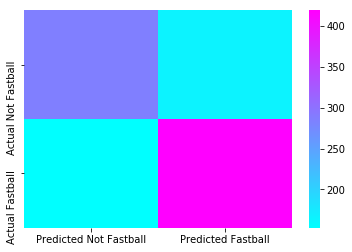

,Predicted Not Fastball,Predicted Fastball
Actual Not Fastball,286,166
Actual Fastball,153,419


In [201]:
# model = search.best_estimator_
model = top10_gbc.model.values[0]
con_matrix_analysis(model, X, X_test, y, y_test)

In [202]:
#get_accuracy_metrics(model, X, y, X_test, y_test)

## Support Vector Machine

In [203]:
#1 hot encode instead of label encode:

In [204]:
# sum = 0
# for col in cat_cols:
#     sum += df[col].nunique()
#     print(col + ': ' + str(df[col].nunique()))
    
# print(sum)

In [205]:
# one_hot_cols = set(cat_cols) - set(['index', 'player_name', 'game_date', 'pitch_cat', 'pitcher', 'pitch_type', 'fastball_target'])

# one_hot_df = pd.get_dummies(df, prefix_sep='_',columns=one_hot_cols)

# train, test = train_test_split_by_date(one_hot_df, .9)

# #target = 'pitch_cat'
# target = 'fastball_target'

# drop_cols = ['index', 'player_name', 'game_date', 'pitch_cat', 'pitcher', 'pitch_type', target]

# X = train.drop(columns=drop_cols)
# X_test = test.drop(columns=drop_cols)

# y = train[target]
# y_test = test[target]

# X.shape, X_test.shape, y.shape, y_test.shape

In [206]:
# #scale the float cols:
# scale_cols = ['fastball_perc_faced', 'fastball_chase_perc', 'fastball_bip_swung_perc', 'fastball_taken_strike_perc',
#               'fastball_est_woba', 'fastball_babip', 'fastball_iso_value', 'breaking_perc_faced', 'breaking_chase_perc',
#               'breaking_bip_swung_perc', 'breaking_taken_strike_perc', 'breaking_est_woba', 'breaking_babip',
#               'breaking_iso_value', 'offspeed_perc_faced', 'offspeed_chase_perc', 'offspeed_bip_swung_perc',
#               'offspeed_taken_strike_perc', 'offspeed_est_woba', 'offspeed_babip', 'offspeed_iso_value',
#               'pitchout_perc_faced', 'overall_fastball_perc', 'count_cat_fastball_perc', 'overall_breaking_perc',
#               'count_cat_breaking_perc', 'overall_offspeed_perc', 'count_cat_offspeed_perc', 'L5_fastball_perc',
#               'L15_fastball_perc', 'L5_breaking_perc', 'L15_breaking_perc', 'L5_offspeed_perc', 'L15_offspeed_perc',
#               'L5_strike_perc', 'L15_strike_perc', 'PB_fastball', 'PB_breaking', 'PB_offspeed']

# scaler = RobustScaler()
# X[scale_cols] = scaler.fit_transform(X[scale_cols].values)
# X_test[scale_cols] = scaler.transform(X_test[scale_cols].values)

In [207]:
%%time
from sklearn.svm import SVC

param_grid = {
    'degree': [2,3,4],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'tol': [0.0001, 0.00001],
    'C': [0.2, 0.5, 1.0, 2.0, 3.5, 5.0],
    'shrinking': [True, False],
    'class_weight': [None],
    'max_iter': [100, 250, 400, 700, 1200, 2000, 3500],
    'decision_function_shape': ['ovo', 'ovr'],
    'gamma': ['auto', 'scale']
}

svm = SVC(random_state=42, verbose=50)

# svm_search = GridSearchCV(
#     estimator = svm, 
#     param_grid=param_grid,
#     scoring='accuracy',
#     n_jobs=-1,
#     cv=3,
#     verbose=10,
#     return_train_score=True
# )

svm_search = RandomizedSearchCV(estimator=svm, param_distributions=param_grid, n_iter=400, 
                            scoring='accuracy', n_jobs=-1, iid='warn', refit=True, cv=3, verbose=10, 
                            random_state=42, error_score='raise-deprecating', return_train_score=True)

svm_search.fit(X, y)

svm_search_results = pd.DataFrame(svm_search.cv_results_).sort_values(by='rank_test_score')

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

[LibSVM]CPU times: user 25.3 s, sys: 406 ms, total: 25.7 s
Wall time: 2min 12s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=3500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [208]:
svm_search_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tol,param_shrinking,param_max_iter,param_kernel,param_gamma,param_degree,param_decision_function_shape,param_class_weight,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
139,2.090760,0.008779,1.016709,0.004015,0.0001,False,3500,rbf,auto,2,ovr,None,0.5,"{'tol': 0.0001, 'shrinking': False, 'max_iter'...",0.656655,0.671967,0.643489,0.657373,0.011637,1,0.889249,0.883652,0.886926,0.886609,0.002296
217,2.154621,0.029501,1.004853,0.017606,1e-05,True,3500,rbf,auto,3,ovo,None,0.5,"{'tol': 1e-05, 'shrinking': True, 'max_iter': ...",0.656655,0.671967,0.643489,0.657373,0.011637,1,0.889249,0.883652,0.886926,0.886609,0.002296
103,2.131941,0.024480,1.004246,0.003522,0.0001,False,3500,rbf,auto,3,ovo,None,0.5,"{'tol': 0.0001, 'shrinking': False, 'max_iter'...",0.656655,0.671967,0.643489,0.657373,0.011637,1,0.889249,0.883652,0.886926,0.886609,0.002296
104,2.030257,0.002060,0.994260,0.006734,0.0001,True,2000,rbf,auto,3,ovr,None,0.5,"{'tol': 0.0001, 'shrinking': True, 'max_iter':...",0.656655,0.671378,0.643489,0.657177,0.011391,4,0.888954,0.883652,0.886926,0.886511,0.002184
16,2.026982,0.030309,1.004997,0.009097,0.0001,False,2000,rbf,auto,4,ovr,None,0.5,"{'tol': 0.0001, 'shrinking': False, 'max_iter'...",0.656655,0.671378,0.643489,0.657177,0.011391,4,0.888954,0.883652,0.886926,0.886511,0.002184


In [209]:
%%time
top10_svm = get_top_n_models(svm_search_results, 'svm', k=30)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=3500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=3500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=3500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or M

CPU times: user 1min 12s, sys: 703 ms, total: 1min 12s
Wall time: 1min 12s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

Not Fastball       0.73      0.28      0.41       452
    Fastball       0.62      0.92      0.74       572

   micro avg       0.64      0.64      0.64      1024
   macro avg       0.67      0.60      0.57      1024
weighted avg       0.67      0.64      0.59      1024



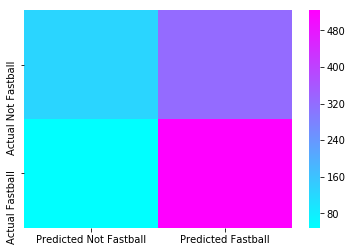

,Predicted Not Fastball,Predicted Fastball
Actual Not Fastball,127,325
Actual Fastball,48,524


In [210]:
# model = search.best_estimator_
model = top10_svm.model.values[0]
con_matrix_analysis(model, X, X_test, y, y_test)

## Linear SVC

In [211]:
%%time
from sklearn.svm import LinearSVC

#L1 Regularization

param_grid = {
    'penalty': ['l1'],
    'loss': ['squared_hinge'],
    'dual': [False],
    'tol': [0.0001, 0.00005, 0.00001],
    'C': [0.2, 0.5, 1.0, 2.0, 3.5, 5.0],
    'class_weight': [None],# 'balanced'
    'max_iter': [50, 100, 250, 400, 700, 1200, 2000],
    'fit_intercept': [True, False]
}

l1_LinSVC = LinearSVC(random_state=42, verbose=50)

l1_LinSVC_search = GridSearchCV(
    estimator = l1_LinSVC, 
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1,
    cv=4,
    verbose=10,
    return_train_score=True
)

# l1_LinSVC_search = RandomizedSearchCV(estimator=svm, param_distributions=param_grid, n_iter=500, 
#                             scoring='accuracy', n_jobs=-1, iid='warn', refit=True, cv=4, verbose=10, 
#                             random_state=42, error_score='raise-deprecating', return_train_score=True)


l1_LinSVC_search.fit(X, y)
l1_LinSVC_search_results = pd.DataFrame(l1_LinSVC_search.cv_results_).sort_values(by='rank_test_score')

Fitting 4 folds for each of 252 candidates, totalling 1008 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1999s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.1967s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 115 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 153 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 170 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:   14.2s
[Parallel(n_j

[LibLinear]CPU times: user 18.6 s, sys: 370 ms, total: 18.9 s
Wall time: 1min 16s


[Parallel(n_jobs=-1)]: Done 1008 out of 1008 | elapsed:  1.3min finished
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [212]:
l1_LinSVC_search_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_dual,param_fit_intercept,param_loss,param_max_iter,param_penalty,param_tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
25,0.231764,0.052845,0.017044,0.000078,0.2,None,False,False,squared_hinge,100,l1,5e-05,"{'C': 0.2, 'class_weight': None, 'dual': False...",0.671115,0.713501,0.683425,0.699686,0.691930,0.016059,1,0.724535,0.717203,0.723822,0.730437,0.723999,0.004689
24,0.227844,0.047671,0.017139,0.000800,0.2,None,False,False,squared_hinge,100,l1,0.0001,"{'C': 0.2, 'class_weight': None, 'dual': False...",0.671115,0.713501,0.683425,0.699686,0.691930,0.016059,1,0.724535,0.717203,0.723822,0.730437,0.723999,0.004689
22,0.162320,0.015375,0.017990,0.000219,0.2,None,False,False,squared_hinge,50,l1,5e-05,"{'C': 0.2, 'class_weight': None, 'dual': False...",0.671115,0.712716,0.683425,0.697327,0.691145,0.015531,3,0.722964,0.718775,0.723822,0.729914,0.723869,0.003978
21,0.166297,0.015626,0.017467,0.000422,0.2,None,False,False,squared_hinge,50,l1,0.0001,"{'C': 0.2, 'class_weight': None, 'dual': False...",0.671115,0.712716,0.683425,0.697327,0.691145,0.015531,3,0.722964,0.718775,0.723822,0.729914,0.723869,0.003978
28,0.422454,0.168813,0.017061,0.000789,0.2,None,False,False,squared_hinge,250,l1,5e-05,"{'C': 0.2, 'class_weight': None, 'dual': False...",0.663265,0.715071,0.683425,0.700472,0.690556,0.019337,5,0.725844,0.719298,0.723822,0.729914,0.724720,0.003822


In [213]:
%%time
top10_l1_LinSVC = get_top_n_models(l1_LinSVC_search_results, 'lin_SVC', k=50)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

CPU times: user 1min 4s, sys: 3.18 s, total: 1min 8s
Wall time: 9.91 s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

Not Fastball       0.66      0.60      0.63       452
    Fastball       0.70      0.75      0.73       572

   micro avg       0.68      0.68      0.68      1024
   macro avg       0.68      0.68      0.68      1024
weighted avg       0.68      0.68      0.68      1024



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


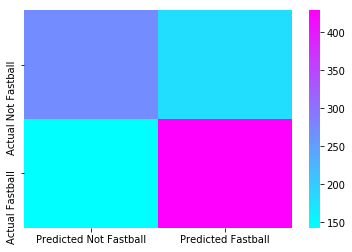

,Predicted Not Fastball,Predicted Fastball
Actual Not Fastball,272,180
Actual Fastball,143,429


In [214]:
# model = search.best_estimator_
model = top10_l1_LinSVC.model.values[0]
con_matrix_analysis(model, X, X_test, y, y_test)

In [215]:
%%time
from sklearn.svm import LinearSVC

#L2 Regularization

#The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

param_grid = {
    'penalty': ['l2'],#, 'l1'],
    'loss': ['squared_hinge'],# 'hinge'],
    'dual': [True, False],
    'tol': [0.0001, 0.00005, 0.00001],
    'C': [0.2, 0.5, 1.0, 2.0, 3.5, 5.0],
    'class_weight': [None], # 'balanced'
    'max_iter': [50, 100, 250, 400, 700, 1200],
    'fit_intercept': [True, False]
}

l2_LinSVC = LinearSVC(random_state=42, verbose=50)

l2_LinSVC_search_A = GridSearchCV(
    estimator = l2_LinSVC, 
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1,
    cv=4,
    verbose=10,
    return_train_score=True
)

l2_LinSVC_search_A.fit(X, y)
l2_LinSVC_search_results_A = pd.DataFrame(l2_LinSVC_search_A.cv_results_).sort_values(by='rank_test_score')

param_grid = {
    'penalty': ['l2'],
    'loss': ['hinge'],
    'dual': [True],
    'tol': [0.0001, 0.00005, 0.00001],
    'C': [0.2, 0.5, 1.0, 2.0, 3.5, 5.0],
    'class_weight': [None], # 'balanced'
    'max_iter': [50, 100, 250, 400, 700, 1200],
    'fit_intercept': [True, False]
}

l2_LinSVC_search_B = GridSearchCV(
    estimator = l2_LinSVC, 
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1,
    cv=4,
    verbose=10,
    return_train_score=True
)

l2_LinSVC_search_B.fit(X, y)
l2_LinSVC_search_results_B = pd.DataFrame(l2_LinSVC_search_B.cv_results_).sort_values(by='rank_test_score')


l2_LinSVC_search_results = pd.concat([l2_LinSVC_search_results_A, l2_LinSVC_search_results_B]).sort_values(by='rank_test_score')

Fitting 4 folds for each of 432 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1810s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.1127s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 111 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 183 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:   12.5s
[Parallel(n_j

[LibLinear]Fitting 4 folds for each of 216 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1945s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.1201s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 111 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 183 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 223 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 

[LibLinear]CPU times: user 48.3 s, sys: 869 ms, total: 49.2 s
Wall time: 2min 33s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [216]:
l2_LinSVC_search_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_dual,param_fit_intercept,param_loss,param_max_iter,param_penalty,param_tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
215,0.108096,0.020599,0.010368,0.000589,1,None,False,False,squared_hinge,1200,l2,1e-05,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.679749,0.718995,0.676355,0.698899,0.693501,0.017049,1,0.709610,0.698874,0.712565,0.730175,0.712806,0.011248
49,1.869922,0.022952,0.019161,0.000430,0.5,None,True,True,hinge,700,l2,5e-05,"{'C': 0.5, 'class_weight': None, 'dual': True,...",0.550235,0.550235,0.549882,0.550314,0.550167,0.000167,1,0.550144,0.550144,0.550262,0.550118,0.550167,0.000056
30,1.823070,0.017720,0.018605,0.000242,0.2,None,True,False,hinge,700,l2,0.0001,"{'C': 0.2, 'class_weight': None, 'dual': True,...",0.550235,0.550235,0.549882,0.550314,0.550167,0.000167,1,0.550144,0.550144,0.550262,0.550118,0.550167,0.000056
48,1.858548,0.015985,0.018656,0.000238,0.5,None,True,True,hinge,700,l2,0.0001,"{'C': 0.5, 'class_weight': None, 'dual': True,...",0.550235,0.550235,0.549882,0.550314,0.550167,0.000167,1,0.550144,0.550144,0.550262,0.550118,0.550167,0.000056
102,1.798267,0.018306,0.018653,0.000217,1,None,True,False,hinge,700,l2,0.0001,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.550235,0.550235,0.549882,0.550314,0.550167,0.000167,1,0.550144,0.550144,0.550262,0.550118,0.550167,0.000056


In [217]:
%%time
top10_l2_LinSVC = get_top_n_models(l2_LinSVC_search_results, 'lin_SVC', k=50)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

CPU times: user 1min 39s, sys: 3.48 s, total: 1min 42s
Wall time: 39.6 s


              precision    recall  f1-score   support

Not Fastball       0.65      0.61      0.63       452
    Fastball       0.70      0.74      0.72       572

   micro avg       0.68      0.68      0.68      1024
   macro avg       0.68      0.67      0.68      1024
weighted avg       0.68      0.68      0.68      1024



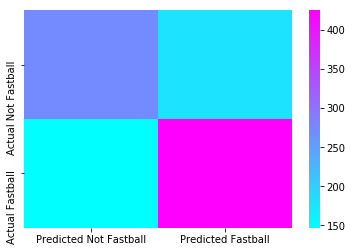

,Predicted Not Fastball,Predicted Fastball
Actual Not Fastball,274,178
Actual Fastball,147,425


In [218]:
# model = search.best_estimator_
model = top10_l2_LinSVC.model.values[0]
con_matrix_analysis(model, X, X_test, y, y_test)

In [219]:
#get_accuracy_metrics(model, X, y, X_test, y_test)

## SGDClassifier

In [220]:
%%time
from sklearn.linear_model import SGDClassifier

param_grid = {
    'penalty': ['l2', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01, 0.02, .05, 0.1],
    'loss': ['squared_hinge', 'hinge', 'perceptron'],
    'tol': [0.0001, 0.00005, 0.00001],
    #'multi_class': ['ovr'],
    'class_weight': [None],
    'max_iter': [1000, 3000, 5000, 10000, 20000, 40000, 100000, 200000],
    'fit_intercept': [True, False],
    'warm_start': [True, False],
    'learning_rate': ['optimal'],
    'shuffle':[True, False]
}

sgd = SGDClassifier(random_state=42, verbose=50)

# search = GridSearchCV(
#     estimator = sgd, 
#     param_grid=param_grid,
#     scoring='accuracy',
#     n_jobs=-1,
#     cv=4,
#     verbose=10,
#     return_train_score=True
# )


sgd_search = RandomizedSearchCV(estimator=sgd, param_distributions=param_grid, n_iter=500, 
                            scoring='accuracy', n_jobs=-1, iid='warn', refit=True, cv=3, verbose=10, 
                            random_state=42, error_score='raise-deprecating', return_train_score=True)

sgd_search.fit(X, y)

sgd_search_results = pd.DataFrame(sgd_search.cv_results_).sort_values(by='rank_test_score')

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

-- Epoch 1
Norm: 3164.26, NNZs: 53, Bias: 0.000000, T: 5093, Avg. loss: 1873645935.729640
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 2643.21, NNZs: 51, Bias: 0.000000, T: 10186, Avg. loss: 204072723.393964
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 2613.40, NNZs: 52, Bias: 0.000000, T: 15279, Avg. loss: 118592487.051634
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 2661.20, NNZs: 53, Bias: 0.000000, T: 20372, Avg. loss: 84332682.797916
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 2653.35, NNZs: 53, Bias: 0.000000, T: 25465, Avg. loss: 64418146.324304
Total training time: 0.02 seconds.
-- Epoch 6
Norm: 2687.20, NNZs: 54, Bias: 0.000000, T: 30558, Avg. loss: 53084917.878124
Total training time: 0.02 seconds.
-- Epoch 7
Norm: 2718.66, NNZs: 54, Bias: 0.000000, T: 35651, Avg. loss: 44614130.800876
Total training time: 0.02 seconds.
-- Epoch 8
Norm: 2746.80, NNZs: 55, Bias: 0.000000, T: 40744, Avg. loss: 39641155.486787
Total training time: 0.02 seconds.
-- Ep

In [221]:
sgd_search_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_warm_start,param_tol,param_shuffle,param_penalty,param_max_iter,param_loss,param_learning_rate,param_fit_intercept,param_class_weight,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
106,0.643610,0.062262,0.019893,0.000303,True,1e-05,True,elasticnet,40000,perceptron,optimal,False,None,0.05,"{'warm_start': True, 'tol': 1e-05, 'shuffle': ...",0.592462,0.550059,0.550383,0.564304,0.019914,1,0.597349,0.550221,0.550059,0.565876,0.022255
247,0.626085,0.065912,0.020052,0.000424,False,5e-05,True,elasticnet,40000,perceptron,optimal,False,None,0.05,"{'warm_start': False, 'tol': 5e-05, 'shuffle':...",0.592462,0.550059,0.550383,0.564304,0.019914,1,0.597349,0.550221,0.550059,0.565876,0.022255
434,0.629488,0.073407,0.019659,0.000311,False,0.0001,True,elasticnet,3000,perceptron,optimal,False,None,0.05,"{'warm_start': False, 'tol': 0.0001, 'shuffle'...",0.592462,0.550059,0.550383,0.564304,0.019914,1,0.597349,0.550221,0.550059,0.565876,0.022255
140,0.638316,0.082041,0.019891,0.000104,False,1e-05,True,elasticnet,10000,perceptron,optimal,False,None,0.05,"{'warm_start': False, 'tol': 1e-05, 'shuffle':...",0.592462,0.550059,0.550383,0.564304,0.019914,1,0.597349,0.550221,0.550059,0.565876,0.022255
142,0.624864,0.080225,0.019820,0.000075,False,0.0001,True,elasticnet,200000,perceptron,optimal,False,None,0.05,"{'warm_start': False, 'tol': 0.0001, 'shuffle'...",0.592462,0.550059,0.550383,0.564304,0.019914,1,0.597349,0.550221,0.550059,0.565876,0.022255


In [222]:
%%time
top10_sgd = get_top_n_models(sgd_search_results, 'sgd', k=100, accuracy_metric='accuracy')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


CPU times: user 2min 35s, sys: 7.1 s, total: 2min 42s
Wall time: 34.2 s


In [223]:
top10_sgd

,model,accuracy,f1_score,r2_score,roc_auc_score,model_type
0,"SGDClassifier(alpha=0.1, average=False, class_...",0.591797,0.727154,-0.655548,N/A,SGDClassifier
0,"SGDClassifier(alpha=0.1, average=False, class_...",0.591797,0.727154,-0.655548,N/A,SGDClassifier
0,"SGDClassifier(alpha=0.1, average=False, class_...",0.591797,0.727154,-0.655548,N/A,SGDClassifier
0,"SGDClassifier(alpha=0.1, average=False, class_...",0.591797,0.727154,-0.655548,N/A,SGDClassifier
0,"SGDClassifier(alpha=0.1, average=False, class_...",0.591797,0.727154,-0.655548,N/A,SGDClassifier
0,"SGDClassifier(alpha=0.1, average=False, class_...",0.591797,0.727154,-0.655548,N/A,SGDClassifier
0,"SGDClassifier(alpha=0.1, average=False, class_...",0.590820,0.726680,-0.659509,N/A,SGDClassifier
0,"SGDClassifier(alpha=0.1, average=False, class_...",0.590820,0.726680,-0.659509,N/A,SGDClassifier
0,"SGDClassifier(alpha=0.02, average=False, class...",0.558594,0.716792,-0.790210,N/A,SGDClassifier
0,"SGDClassifier(alpha=0.0001, average=False, cla...",0.558594,0.716792,-0.790210,N/A,SGDClassifier


              precision    recall  f1-score   support

Not Fastball       0.77      0.11      0.19       452
    Fastball       0.58      0.97      0.73       572

   micro avg       0.59      0.59      0.59      1024
   macro avg       0.67      0.54      0.46      1024
weighted avg       0.66      0.59      0.49      1024



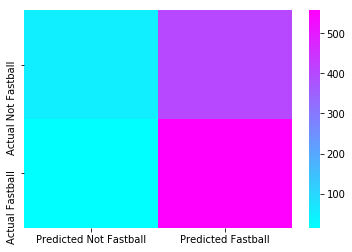

,Predicted Not Fastball,Predicted Fastball
Actual Not Fastball,49,403
Actual Fastball,15,557


In [224]:
# model = search.best_estimator_
model = top10_sgd.model.values[0]
con_matrix_analysis(model, X, X_test, y, y_test)

## LDA

In [225]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

param_grid = {
    'solver': ['lsqr'],#, 'eigen'],
    'shrinkage': [None, 'auto', 0.1, 0.5],
    'tol': [0.0001, 0.00005, 0.00001],
    'n_components':[None, 25, 50, 75, 100],
    #'store_covariance': [True, False]
}

lda = LinearDiscriminantAnalysis()

lda_search = GridSearchCV(
    estimator = lda, 
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1,
    cv=8,
    verbose=10,
    return_train_score=True
)

lda_search.fit(X, y)

lda_search_results = pd.DataFrame(lda_search.cv_results_).sort_values(by='rank_test_score')

Fitting 8 folds for each of 60 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1488s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 346 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 388 ta

In [226]:
lda_search_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_components,param_shrinkage,param_solver,param_tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,mean_train_score,std_train_score
29,0.163604,0.010257,0.011201,0.000410,50,auto,lsqr,1e-05,"{'n_components': 50, 'shrinkage': 'auto', 'sol...",0.65047,0.711599,0.717425,0.715409,0.65566,0.669811,0.677673,0.694969,0.686629,0.025253,1,0.729517,0.716498,0.72307,0.725376,0.724254,0.729414,0.729414,0.7256,0.725393,0.004111
27,0.163925,0.003688,0.011492,0.000445,50,auto,lsqr,0.0001,"{'n_components': 50, 'shrinkage': 'auto', 'sol...",0.65047,0.711599,0.717425,0.715409,0.65566,0.669811,0.677673,0.694969,0.686629,0.025253,1,0.729517,0.716498,0.72307,0.725376,0.724254,0.729414,0.729414,0.7256,0.725393,0.004111
28,0.159789,0.002517,0.010676,0.001529,50,auto,lsqr,5e-05,"{'n_components': 50, 'shrinkage': 'auto', 'sol...",0.65047,0.711599,0.717425,0.715409,0.65566,0.669811,0.677673,0.694969,0.686629,0.025253,1,0.729517,0.716498,0.72307,0.725376,0.724254,0.729414,0.729414,0.7256,0.725393,0.004111
17,0.164680,0.009135,0.011563,0.000612,25,auto,lsqr,1e-05,"{'n_components': 25, 'shrinkage': 'auto', 'sol...",0.65047,0.711599,0.717425,0.715409,0.65566,0.669811,0.677673,0.694969,0.686629,0.025253,1,0.729517,0.716498,0.72307,0.725376,0.724254,0.729414,0.729414,0.7256,0.725393,0.004111
16,0.161443,0.006466,0.011252,0.000553,25,auto,lsqr,5e-05,"{'n_components': 25, 'shrinkage': 'auto', 'sol...",0.65047,0.711599,0.717425,0.715409,0.65566,0.669811,0.677673,0.694969,0.686629,0.025253,1,0.729517,0.716498,0.72307,0.725376,0.724254,0.729414,0.729414,0.7256,0.725393,0.004111


In [227]:
%%time
top10_lda = get_top_n_models(lda_search_results, 'lda', k=50)
top10_lda

CPU times: user 34.2 s, sys: 1.75 s, total: 36 s
Wall time: 4.5 s


              precision    recall  f1-score   support

Not Fastball       0.67      0.59      0.62       452
    Fastball       0.70      0.77      0.73       572

   micro avg       0.69      0.69      0.69      1024
   macro avg       0.69      0.68      0.68      1024
weighted avg       0.69      0.69      0.69      1024



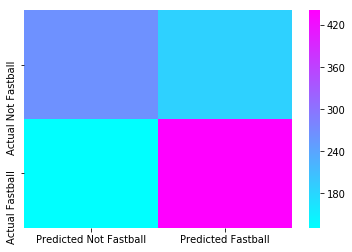

,Predicted Not Fastball,Predicted Fastball
Actual Not Fastball,265,187
Actual Fastball,131,441


In [228]:
model = top10_lda.model.values[0]
con_matrix_analysis(model, X, X_test, y, y_test)

## Save the work

In [235]:
#combine all the top10s into one df and save to pickle file

best_models = pd.concat([top10_rfc_bootstrap, top10_rfc_without_bootstrap, top10_gbc, top10_svm, top10_l1_LinSVC, top10_l2_LinSVC,
                         top10_sgd, top10_lda])

In [236]:
best_models.to_pickle(path=(pitcher+'_best_models_v1.pkl'),compression='zip')

In [21]:
# test = pd.read_pickle(pitcher+'_best_models_v1.pkl', compression='zip')
# test.sort_values(by='accuracy', ascending=False).head(20)